# Exercise 08

## Gradient-based attribution methods for deep neural networks

### Vanilla Gradient (Saliency map)

Use the following code as a basis to calculate a vanilla saliency map.

Hints:

- you can set the class outputs for other classes to zero by using specifying `gradient` in `backward(gradient=)`, or by applying `torch.max` to the predictions if you want to explain the predicted class

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
#load pretrained resnet model
model = torchvision.models.resnet50(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
]);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
#https://drive.google.com/file/d/1BNb2ODeeH_5g5T6qJpZ1GuyeSeJNTRbg/view?usp=sharing
img = Image.open('puppy.jpg').convert('RGB')
img_normalized = transform(img).unsqueeze(0)
#we don't need gradients w.r.t. weights for a trained model
for param in model.parameters():
    param.requires_grad = False

#set model in eval mode
model.eval()

#we want to calculate gradient of highest score w.r.t. input
#so set requires_grad to True for input
img_normalized.requires_grad = True
# TODO
value,index = torch.max(model(img_normalized), 1)

value.backward()

sal , ìnd = torch.max(img_normalized.grad[0],0)

v,i = torch.max(model(img_normalized),1)
print(v)
print(i)
torch.max(model(img_normalized),1)

torch.max(model(img_normalized),1)
img_normalized.grad[0].shape

tensor([4.9406], grad_fn=<MaxBackward0>)
tensor([207])


torch.Size([3, 224, 224])

In [62]:
def saliency(input, model):
    img = Image.open('puppy.jpg').convert('RGB')
    img_normalized = transform(img).unsqueeze(0)
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()

    #we want to calculate gradient of highest score w.r.t. input
    #so set requires_grad to True for input
    #gets the .requires_grad from torch transform
    img_normalized.requires_grad = True


    # DAs Model predicted das inputBild, gibt den letzten Klassifizeirungsvektor raus
    pred = model(img_normalized)
    # Von diesem Vektor nehmen wir das Neuron mit dem max Wert, und den Connections...
    value,index = torch.max(pred, 1)

    #Rückwartsfunktion, wie backpropagation,
    # aber alle wheights sind ausgeschaltet im Netz ausser den Wheights des Inputs
    value.backward()

    #img_normalized.grad.shape = torch.Size([1, 3, 224, 224])
    # die erste Dimension ist die Batchsize (hier ja nur ein Bild)
    #img_normalized.grad[0].shape = img_normalized.grad[0].shape
    sal , _ = torch.max(torch.abs(img_normalized.grad[0]),0)


    sal[sal>255] = 255

    return sal.numpy()

In [63]:
def plot(input_img, saliencey_map):
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(saliencey_map, cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

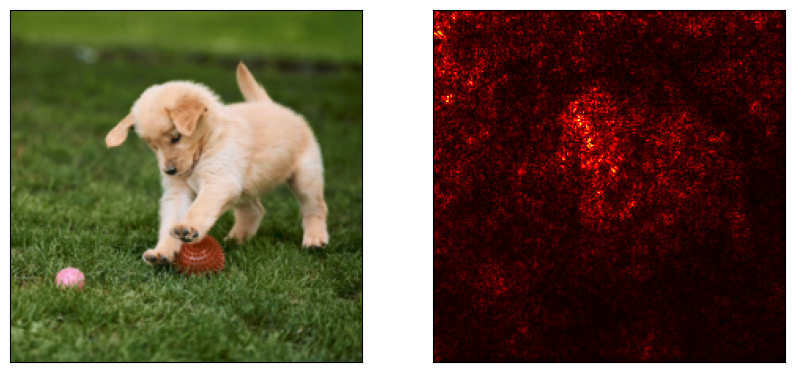

In [57]:
img = Image.open('puppy.jpg').convert('RGB')

# transform and normalize image and put it in a stack
img_normalized = transform(img).unsqueeze(0)
# unstack and unnormalize image
img_normalized_inv = inv_normalize(img_normalized[0])

# calculate saliency map
saliencey_map = saliency(img_normalized, model)

# plot image and saliency map
plot(img_normalized_inv, saliencey_map)

### Smooth Grad

**Question**: Implement Smooth grad with at least 10 runs.

In [ ]:
#average saliency maps
# (
# hints:
# 1.load puppy image
# 2. add random noise to it
# 3. calculate saliency map for each noisy image
# 4. average saliency maps
# )

# TODO

saliencey_map = None

In [ ]:
# plot
img = Image.open('puppy.jpg').convert('RGB')
img_normalized = transform(img).unsqueeze(0)
img_normalized_inv = inv_normalize(img_normalized[0])

plot(img_normalized_inv, saliencey_map)